## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
from sklearn import preprocessing

In [6]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
        x = preprocessing.MinMaxScaler(feature_range=(-1,1)).fit_transform(x)
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [7]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [17]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model


In [27]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [19]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.3,0.5,0.8]
redice_lr_patient = [5,10]

In [28]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    #####itertolls!!!!!
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)

#monitor: 被监测的数据。
#factor: 学习速率被降低的因数。新的学习速率 = 学习速率 * 因数
#patience: 没有进步的训练轮数，在这之后训练速率会被降低。
#verbose: 整数。0：安静，1：更新信息。
#mode: {auto, min, max} 其中之一。如果是 min 模式，学习速率会被降低如果被监测的数据已经停止下降；
#    在 max 模式，学习塑料会被降低如果被监测的数据已经停止上升； 在 auto 模式，方向会被从被监测的数据中自动推断出来。
#min_delta: 对于测量新的最优化的阀值，只关注巨大的改变。
#cooldown: 在学习速率被降低之后，重新恢复正常操作之前等待的训练轮数量。
#min_lr: 学习速率的下边界。
  
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.30, reduce_patient: 5
Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_70 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_71 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________


50000/50000 [==============================] - 5s 109us/step - loss: 1.2890 - accuracy: 0.5525 - val_loss: 1.4980 - val_accuracy: 0.4693
Epoch 11/25
50000/50000 [==============================] - 5s 109us/step - loss: 1.2607 - accuracy: 0.5629 - val_loss: 1.4895 - val_accuracy: 0.4713
Epoch 12/25
50000/50000 [==============================] - 5s 109us/step - loss: 1.2322 - accuracy: 0.5722 - val_loss: 1.4805 - val_accuracy: 0.4728
Epoch 13/25
50000/50000 [==============================] - 6s 113us/step - loss: 1.2071 - accuracy: 0.5829 - val_loss: 1.4768 - val_accuracy: 0.4747
Epoch 14/25
50000/50000 [==============================] - 5s 108us/step - loss: 1.1815 - accuracy: 0.5918 - val_loss: 1.4680 - val_accuracy: 0.4801
Epoch 15/25
50000/50000 [==============================] - 5s 108us/step - loss: 1.1569 - accuracy: 0.6012 - val_loss: 1.4653 - val_accuracy: 0.4764
Epoch 16/25
50000/50000 [==============================] - 5s 109us/step - loss: 1.1326 - accuracy: 0.6108 - val_loss:

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 6s 122us/step - loss: 2.3609 - accuracy: 0.2272 - val_loss: 2.0770 - val_accuracy: 0.2923
Epoch 2/25
50000/50000 [==============================] - 5s 106us/step - loss: 1.8792 - accuracy: 0.3490 - val_loss: 1.9264 - val_accuracy: 0.3480
Epoch 3/25
50000/50000 [==============================] - 5s 106us/step - loss: 1.7392 - accuracy: 0.3926 - val_loss: 1.8128 - val_accuracy: 0.3772
Epoch 4/25
50000/50000 [==============================] - 5s 106us/step - loss: 1.6626 - accuracy: 0.4178 - val_loss: 1.7271 - val_accuracy: 0.3977
Epoch 5/25
50000/50000 [==============================] - 5s 106us/step - loss: 1.6075 - accuracy: 0.4367 - val_loss: 1.6746 - val_accuracy: 0.4107
Epoch 6/25
50000/50000 [==============================] - 5s 105us/step - loss: 1.5650 - accuracy: 0.4518 - val_loss: 1.6407 - val_accuracy: 0.4234
Epoch 7/25
50000/50000 [==============================] - 5s 1

50000/50000 [==============================] - 5s 108us/step - loss: 1.2581 - accuracy: 0.5656 - val_loss: 1.5008 - val_accuracy: 0.4685
Epoch 21/25
50000/50000 [==============================] - 5s 108us/step - loss: 1.2434 - accuracy: 0.5695 - val_loss: 1.4963 - val_accuracy: 0.4711
Epoch 22/25
50000/50000 [==============================] - 7s 133us/step - loss: 1.2291 - accuracy: 0.5756 - val_loss: 1.4934 - val_accuracy: 0.4709
Epoch 23/25
50000/50000 [==============================] - 5s 109us/step - loss: 1.2148 - accuracy: 0.5817 - val_loss: 1.4903 - val_accuracy: 0.4766
Epoch 24/25
50000/50000 [==============================] - 7s 136us/step - loss: 1.2017 - accuracy: 0.5876 - val_loss: 1.4884 - val_accuracy: 0.4746
Epoch 25/25
50000/50000 [==============================] - 5s 108us/step - loss: 1.1875 - accuracy: 0.5921 - val_loss: 1.4845 - val_accuracy: 0.4773
Numbers of exp: 5, reduce_factor: 0.80, reduce_patient: 10
Model: "model_29"
_________________________________________

Epoch 5/25
50000/50000 [==============================] - 6s 113us/step - loss: 1.1862 - accuracy: 0.5819 - val_loss: 1.3739 - val_accuracy: 0.5104
Epoch 6/25
50000/50000 [==============================] - 5s 108us/step - loss: 1.1168 - accuracy: 0.6057 - val_loss: 1.3482 - val_accuracy: 0.5265
Epoch 7/25
50000/50000 [==============================] - 5s 107us/step - loss: 1.0468 - accuracy: 0.6305 - val_loss: 1.3313 - val_accuracy: 0.5320
Epoch 8/25
50000/50000 [==============================] - 5s 106us/step - loss: 0.9844 - accuracy: 0.6528 - val_loss: 1.3398 - val_accuracy: 0.5338
Epoch 9/25
50000/50000 [==============================] - 5s 106us/step - loss: 0.9211 - accuracy: 0.6767 - val_loss: 1.3691 - val_accuracy: 0.5282
Epoch 10/25
50000/50000 [==============================] - 5s 106us/step - loss: 0.8605 - accuracy: 0.6963 - val_loss: 1.3913 - val_accuracy: 0.5251
Epoch 11/25
50000/50000 [==============================] - 5s 105us/step - loss: 0.8067 - accuracy: 0.7183 - va

50000/50000 [==============================] - 5s 106us/step - loss: 1.0059 - accuracy: 0.6642 - val_loss: 1.4593 - val_accuracy: 0.4885
Epoch 24/25
50000/50000 [==============================] - 5s 106us/step - loss: 0.9933 - accuracy: 0.6708 - val_loss: 1.4590 - val_accuracy: 0.4914
Epoch 25/25
50000/50000 [==============================] - 5s 105us/step - loss: 0.9807 - accuracy: 0.6747 - val_loss: 1.4585 - val_accuracy: 0.4897
Numbers of exp: 8, reduce_factor: 0.50, reduce_patient: 5
Model: "model_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_94 (Batc (None, 256)               1024      
___________________________

Epoch 8/25
50000/50000 [==============================] - 5s 98us/step - loss: 1.2680 - accuracy: 0.5628 - val_loss: 1.4761 - val_accuracy: 0.4784
Epoch 9/25
50000/50000 [==============================] - 5s 99us/step - loss: 1.2398 - accuracy: 0.5742 - val_loss: 1.4717 - val_accuracy: 0.4808
Epoch 10/25
50000/50000 [==============================] - 5s 101us/step - loss: 1.2138 - accuracy: 0.5835 - val_loss: 1.4627 - val_accuracy: 0.4856
Epoch 11/25
50000/50000 [==============================] - 5s 99us/step - loss: 1.1901 - accuracy: 0.5927 - val_loss: 1.4586 - val_accuracy: 0.4855
Epoch 12/25
50000/50000 [==============================] - 5s 99us/step - loss: 1.1679 - accuracy: 0.5989 - val_loss: 1.4573 - val_accuracy: 0.4855
Epoch 13/25
50000/50000 [==============================] - 5s 98us/step - loss: 1.1469 - accuracy: 0.6089 - val_loss: 1.4539 - val_accuracy: 0.4895
Epoch 14/25
50000/50000 [==============================] - 5s 98us/step - loss: 1.1266 - accuracy: 0.6157 - val_l

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 6s 116us/step - loss: 2.0359 - accuracy: 0.3162 - val_loss: 1.9674 - val_accuracy: 0.3548
Epoch 2/25
50000/50000 [==============================] - 5s 100us/step - loss: 1.6436 - accuracy: 0.4250 - val_loss: 1.8085 - val_accuracy: 0.4048
Epoch 3/25
50000/50000 [==============================] - 5s 100us/step - loss: 1.5430 - accuracy: 0.4599 - val_loss: 1.6920 - val_accuracy: 0.4286
Epoch 4/25
50000/50000 [==============================] - 5s 100us/step - loss: 1.4785 - accuracy: 0.4848 - val_loss: 1.6187 - val_accuracy: 0.4359
Epoch 5/25
50000/50000 [==============================] - 5s 101us/step - loss: 1.4306 - accuracy: 0.5019 - val_loss: 1.5723 - val_accuracy: 0.4481
Epoch 6/25
50000/50000 [==============================] - 5s 100us/step - loss: 1.3914 - accuracy: 0.5176 - val_loss: 1.5442 - val_accuracy: 0.4572
Epoch 7/25
50000/50000 [==============================] - 5s 1

50000/50000 [==============================] - 5s 106us/step - loss: 0.2889 - accuracy: 0.9310 - val_loss: 1.5751 - val_accuracy: 0.5318
Epoch 20/25
50000/50000 [==============================] - 6s 121us/step - loss: 0.2765 - accuracy: 0.9345 - val_loss: 1.5992 - val_accuracy: 0.5284
Epoch 21/25
50000/50000 [==============================] - 5s 99us/step - loss: 0.2651 - accuracy: 0.9390 - val_loss: 1.6251 - val_accuracy: 0.5299
Epoch 22/25
50000/50000 [==============================] - 5s 98us/step - loss: 0.2558 - accuracy: 0.9422 - val_loss: 1.6449 - val_accuracy: 0.5262

Epoch 00022: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.
Epoch 23/25
50000/50000 [==============================] - 5s 98us/step - loss: 0.2366 - accuracy: 0.9498 - val_loss: 1.6527 - val_accuracy: 0.5265
Epoch 24/25
50000/50000 [==============================] - 5s 106us/step - loss: 0.2306 - accuracy: 0.9530 - val_loss: 1.6652 - val_accuracy: 0.5257
Epoch 25/25
50000/50000 [===============

50000/50000 [==============================] - 5s 98us/step - loss: 1.7984 - accuracy: 0.3796 - val_loss: 1.8511 - val_accuracy: 0.3626
Epoch 4/25
50000/50000 [==============================] - 5s 98us/step - loss: 1.7049 - accuracy: 0.4068 - val_loss: 1.7635 - val_accuracy: 0.3839
Epoch 5/25
50000/50000 [==============================] - 5s 98us/step - loss: 1.6373 - accuracy: 0.4306 - val_loss: 1.7090 - val_accuracy: 0.3975
Epoch 6/25
50000/50000 [==============================] - 5s 98us/step - loss: 1.5848 - accuracy: 0.4472 - val_loss: 1.6710 - val_accuracy: 0.4146
Epoch 7/25
50000/50000 [==============================] - 5s 101us/step - loss: 1.5415 - accuracy: 0.4618 - val_loss: 1.6470 - val_accuracy: 0.4222
Epoch 8/25
50000/50000 [==============================] - 5s 98us/step - loss: 1.5019 - accuracy: 0.4775 - val_loss: 1.6260 - val_accuracy: 0.4320
Epoch 9/25
50000/50000 [==============================] - 5s 101us/step - loss: 1.4677 - accuracy: 0.4889 - val_loss: 1.6100 - v

50000/50000 [==============================] - 5s 94us/step - loss: 1.1842 - accuracy: 0.5944 - val_loss: 1.5014 - val_accuracy: 0.4716
Epoch 24/25
50000/50000 [==============================] - 5s 92us/step - loss: 1.1698 - accuracy: 0.6008 - val_loss: 1.4988 - val_accuracy: 0.4728
Epoch 25/25
50000/50000 [==============================] - 5s 97us/step - loss: 1.1554 - accuracy: 0.6051 - val_loss: 1.4949 - val_accuracy: 0.4755
Numbers of exp: 16, reduce_factor: 0.80, reduce_patient: 5
Model: "model_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_41 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_118 (Bat (None, 256)               1024      
_____________________________

Epoch 8/25
50000/50000 [==============================] - 6s 118us/step - loss: 1.5017 - accuracy: 0.4733 - val_loss: 1.6188 - val_accuracy: 0.4297
Epoch 9/25
50000/50000 [==============================] - 7s 147us/step - loss: 1.4692 - accuracy: 0.4853 - val_loss: 1.6043 - val_accuracy: 0.4331
Epoch 10/25
50000/50000 [==============================] - 6s 117us/step - loss: 1.4397 - accuracy: 0.4970 - val_loss: 1.5915 - val_accuracy: 0.4379
Epoch 11/25
50000/50000 [==============================] - 6s 125us/step - loss: 1.4132 - accuracy: 0.5059 - val_loss: 1.5781 - val_accuracy: 0.4428
Epoch 12/25
50000/50000 [==============================] - 8s 160us/step - loss: 1.3872 - accuracy: 0.5151 - val_loss: 1.5686 - val_accuracy: 0.4462
Epoch 13/25
50000/50000 [==============================] - 6s 115us/step - loss: 1.3641 - accuracy: 0.5251 - val_loss: 1.5604 - val_accuracy: 0.4495
Epoch 14/25
50000/50000 [==============================] - 6s 123us/step - loss: 1.3422 - accuracy: 0.5322 -

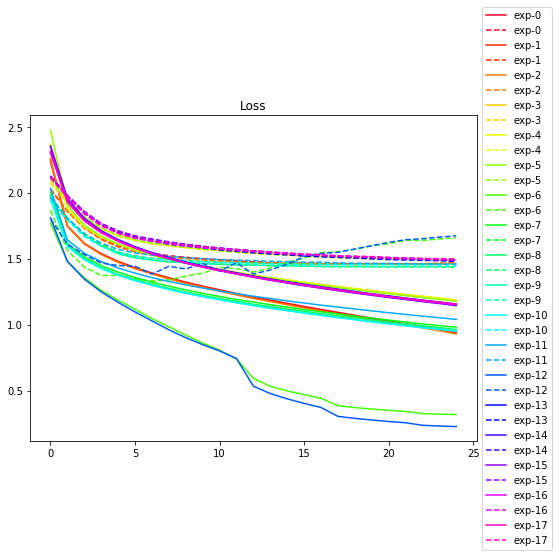

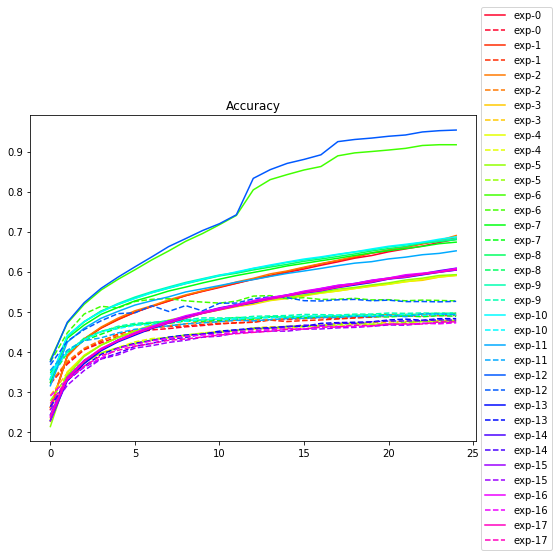

In [29]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

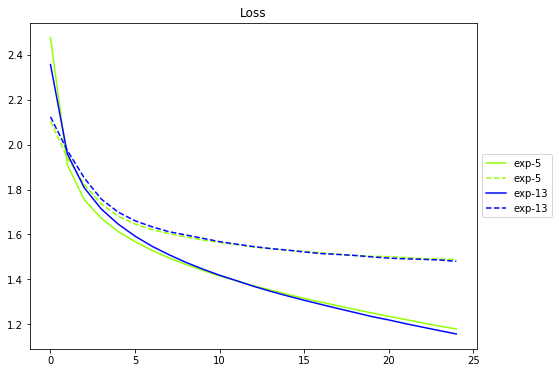

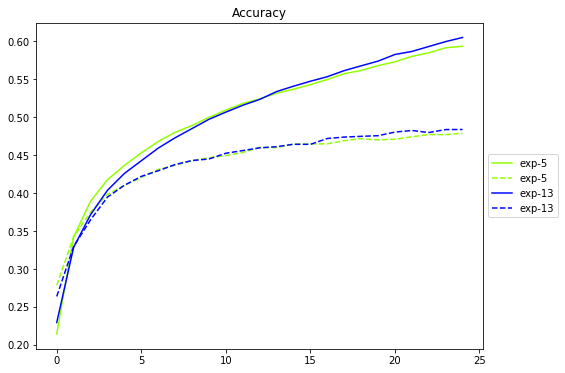

In [49]:

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    if i==13 or i==5:
        plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
        
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    if i==13 or i==5:
        plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [32]:
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    #####itertolls!!!!!
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i, optimizer: %s" % (i, reduce_factor, reduce_patient, optim))

Numbers of exp: 0, reduce_factor: 0.30, reduce_patient: 5, optimizer: <keras.optimizers.SGD object at 0x1a49fef490>
Numbers of exp: 1, reduce_factor: 0.30, reduce_patient: 10, optimizer: <keras.optimizers.SGD object at 0x1a49fef490>
Numbers of exp: 2, reduce_factor: 0.50, reduce_patient: 5, optimizer: <keras.optimizers.SGD object at 0x1a49fef490>
Numbers of exp: 3, reduce_factor: 0.50, reduce_patient: 10, optimizer: <keras.optimizers.SGD object at 0x1a49fef490>
Numbers of exp: 4, reduce_factor: 0.80, reduce_patient: 5, optimizer: <keras.optimizers.SGD object at 0x1a49fef490>
Numbers of exp: 5, reduce_factor: 0.80, reduce_patient: 10, optimizer: <keras.optimizers.SGD object at 0x1a49fef490>
Numbers of exp: 6, reduce_factor: 0.30, reduce_patient: 5, optimizer: <keras.optimizers.Adam object at 0x11054cf50>
Numbers of exp: 7, reduce_factor: 0.30, reduce_patient: 10, optimizer: <keras.optimizers.Adam object at 0x11054cf50>
Numbers of exp: 8, reduce_factor: 0.50, reduce_patient: 5, optimizer